In [58]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
import librosa
from scipy.ndimage import zoom
import soundfile as sf
from scipy.signal import butter, filtfilt

In [59]:
SAMPLING_RATE = 16000
DATASET_PATH = "./dataset/"
CRACK_MELS_FILENAME = "./dataset/crack/mels.npy"
NO_CRACK_MELS_FILENAME = "./dataset/no_crack/mels.npy"

In [60]:
def low_cut_filter(data, cutoff_freq, sample_rate, order=5):
    # Design a Butterworth low-cut filter
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [61]:
datas = {
    "mapping" : [],
    "labels" : [],
    "mels" : []
}

datas["mapping"].append("crack")
datas["mapping"].append("no_crack")

def load_data(path, label):
    loaded_data = np.load(path)
    for mels in loaded_data:
        datas["mels"].append(mels)
        datas["labels"].append(label)

load_data(CRACK_MELS_FILENAME, 0)
load_data(NO_CRACK_MELS_FILENAME, 1)


In [62]:
# # convert lists to numpy arrays
X = np.array(datas["mels"])
y = np.array(datas["labels"])

# Create training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [63]:
print(X.shape)
print(y.shape)
print(np.isnan(X_train).sum())  # Should return 0 if no NaNs
print(np.min(X_train))
print(np.min(y_train))
print(np.max(X_train))
print(np.max(y_train))

(34, 128, 128, 1)
(34,)
0
-80.0
0
0.0
1


In [64]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(2, activation='softmax')
])

In [65]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               8389120   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dropout_11 (Dropout)        (None, 64)               

In [66]:
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 34.2249 - accuracy: 0.5652 - val_loss: 35.7619 - val_accuracy: 0.5455
Epoch 2/200
1/1 [==============================] - 0s 147ms/step - loss: 33.4329 - accuracy: 0.6087 - val_loss: 22.2581 - val_accuracy: 0.4545
Epoch 3/200
1/1 [==============================] - 0s 152ms/step - loss: 32.5176 - accuracy: 0.5217 - val_loss: 18.9266 - val_accuracy: 0.4545
Epoch 4/200
1/1 [==============================] - 0s 135ms/step - loss: 20.9256 - accuracy: 0.6087 - val_loss: 7.5264 - val_accuracy: 0.4545
Epoch 5/200
1/1 [==============================] - 0s 99ms/step - loss: 16.8536 - accuracy: 0.6087 - val_loss: 8.5639 - val_accuracy: 0.5455
Epoch 6/200
1/1 [==============================] - 0s 109ms/step - loss: 51.8837 - accuracy: 0.3043 - val_loss: 17.2039 - val_accuracy: 0.5455
Epoch 7/200
1/1 [==============================] - 0s 112ms/step - loss: 30.5689 - accuracy: 0.5217 - val_loss: 6.5399 - val_accuracy: 0.5455
Epoch 

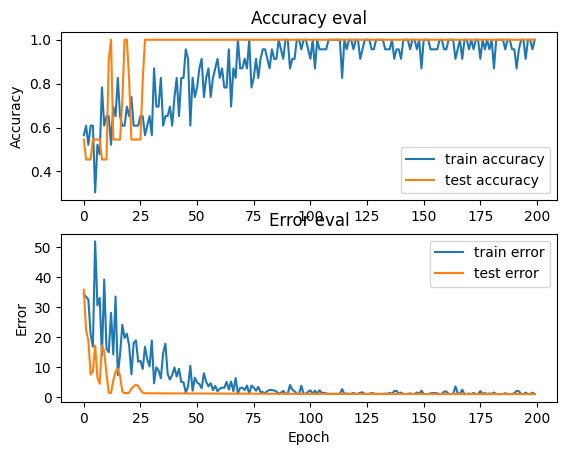

In [67]:
# evaluate model
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

In [80]:
# Create traffic noise dataset

filepath = './dataset/raw/roast3.wav'
segment_duration = 0.2 #seconds
segment_shift = 0.05 #seconds

# Load an audio file
audio, sr = librosa.load(filepath, sr=SAMPLING_RATE)
audio = low_cut_filter(data=audio, cutoff_freq=500.0, sample_rate=sr)

# Calculate samples per segment
samples_per_segment = int(segment_duration * sr)
samples_per_segment_shift = int(segment_shift * sr)

# Split audio into segments
segments = []
for start in range(0, len(audio), samples_per_segment_shift):
    end = start + samples_per_segment
    segment = audio[start:end]
    segments.append(segment)

    print(f"processing segment-{len(segments)} {start}:{end}")

    # if(len(segments) >= segment_count_total) :
        # break

segment_mels = []

for idx, segment in enumerate(segments):
    # Convert audio to Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, fmax=8000)

    # Normalized version
    S = mel_spectrogram
    S_min = S.min()
    S_max = S.max()

    mel_spectrogram = (S - S_min) / (S_max - S_min)
    
    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    log_mel_spectrogram = zoom(log_mel_spectrogram, (128/log_mel_spectrogram.shape[0], 128/log_mel_spectrogram.shape[1]), order=1)  # SciPy

    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    print(np.array(log_mel_spectrogram).shape)
    
    segment_mels.append(log_mel_spectrogram)

# datas
np_input_mels = np.array(segment_mels)

processing segment-1 0:3200
processing segment-2 800:4000
processing segment-3 1600:4800
processing segment-4 2400:5600
processing segment-5 3200:6400
processing segment-6 4000:7200
processing segment-7 4800:8000
processing segment-8 5600:8800
processing segment-9 6400:9600
processing segment-10 7200:10400
processing segment-11 8000:11200
processing segment-12 8800:12000
processing segment-13 9600:12800
processing segment-14 10400:13600
processing segment-15 11200:14400
processing segment-16 12000:15200
processing segment-17 12800:16000
processing segment-18 13600:16800
processing segment-19 14400:17600
processing segment-20 15200:18400
processing segment-21 16000:19200
processing segment-22 16800:20000
processing segment-23 17600:20800
processing segment-24 18400:21600
processing segment-25 19200:22400
processing segment-26 20000:23200
processing segment-27 20800:24000
processing segment-28 21600:24800
processing segment-29 22400:25600
processing segment-30 23200:26400
processing segm

/media/jetson_ssd/e_ear/.env/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2040
  warnings.warn(
/media/jetson_ssd/e_ear/.env/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1240
  warnings.warn(
/media/jetson_ssd/e_ear/.env/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=440
  warnings.warn(


In [81]:
# result = model.predict(np_traffic_noises[0].reshape(1, 128,128, 1))
results = model.predict(np_input_mels)
# print(results)

has_crack_idx = []

for idx, data in enumerate(results):
    if data[0] > data[1]:
        print(data)
        print(f"idx {idx} has crack")
        has_crack_idx.append(idx)
    else:
        # print(1)
        continue

print(f"{len(has_crack_idx)} segment has crack")

166/166 [==============================] - 2s 10ms/step
[9.9999869e-01 1.2523428e-06]
idx 0 has crack
[9.999950e-01 4.982134e-06]
idx 1 has crack
[0.9982028  0.00179716]
idx 289 has crack
[0.91322637 0.08677358]
idx 872 has crack
[0.701714   0.29828602]
idx 1177 has crack
[9.9910933e-01 8.9062034e-04]
idx 1306 has crack
[0.8921578  0.10784218]
idx 1535 has crack
[0.97509253 0.02490743]
idx 1761 has crack
[9.9999976e-01 2.0651338e-07]
idx 1983 has crack
[0.97903514 0.02096485]
idx 2035 has crack
[9.9999428e-01 5.7038433e-06]
idx 2036 has crack
[1.0000000e+00 2.6372437e-11]
idx 2218 has crack
[0.98147374 0.01852627]
idx 2241 has crack
[0.99793774 0.00206223]
idx 3630 has crack
[9.9999738e-01 2.5967036e-06]
idx 4925 has crack
[9.9940670e-01 5.9332914e-04]
idx 4926 has crack
[0.93604136 0.06395861]
idx 4927 has crack
[0.7253808  0.27461925]
idx 5014 has crack
[0.57512385 0.42487612]
idx 5044 has crack
[0.892742   0.10725804]
idx 5050 has crack
20 segment has crack


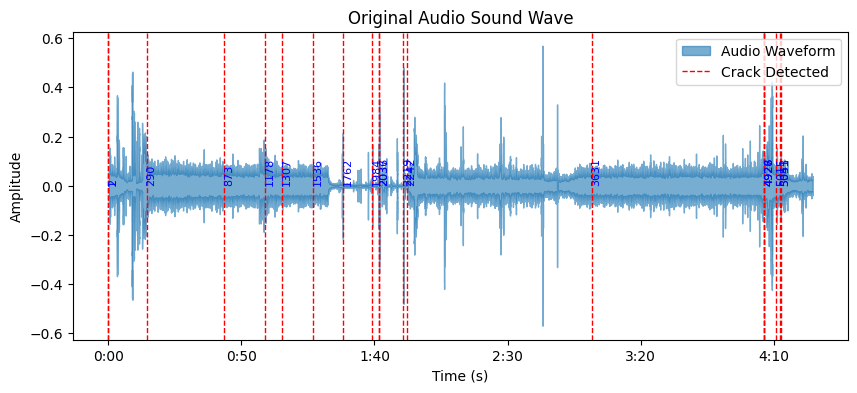

In [82]:
# Plot the original audio sound wave
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr, alpha=0.6, label="Audio Waveform")
plt.title('Original Audio Sound Wave')

segment_count = 0
has_crack_idx_i = 0
not_yet_line = True
# Add vertical lines for each segment
for idx, start in enumerate(range(0, len(audio), samples_per_segment_shift)):
    # Convert the start sample index to time in seconds and draw a vertical line

    if( has_crack_idx_i < len(has_crack_idx) and
        segment_count == has_crack_idx[has_crack_idx_i]
        ):
        start_time = start / sr
        plt.axvline(x=start_time, color='r', linestyle='--', linewidth=1, label='Crack Detected' if not_yet_line else "")  # Red dashed lines for segment starts
        plt.text(start_time, 0, f'{idx+1}', rotation=90, verticalalignment='bottom', fontsize=8, color='blue')  # Label segment number

        has_crack_idx_i = has_crack_idx_i + 1
        not_yet_line = False

    segment_count = segment_count + 1


# Show the plot
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="upper right")
plt.show()

(128, 128)


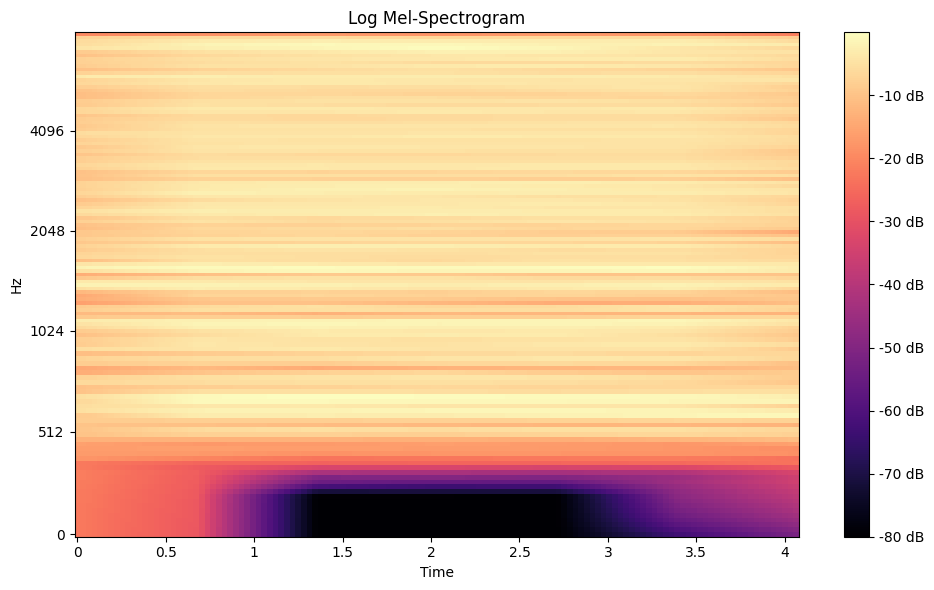

In [83]:
def draw_spectro_at_idx(idx):
    log_mel_spectrogram = np_input_mels[idx].reshape(128,128)
    print(np.array(log_mel_spectrogram).shape)

    # Plot the Mel-spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_mel_spectrogram, sr=16000, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel-Spectrogram')
    plt.tight_layout()
    plt.show()

draw_spectro_at_idx(has_crack_idx[0])

In [84]:
# Save the audio segments as a WAV file
def save_segment_as_wav(segment, num):
    output_file = f'./output/has_crack.{str((num)).zfill(5)}.wav'
    sf.write(output_file, segment, samplerate=SAMPLING_RATE)

for idx, data in enumerate(has_crack_idx):
    save_segment_as_wav(segment=segments[data], num=idx)